In [108]:
%matplotlib inline
import os
import logging
import sys
import numpy as np
import matplotlib.pyplot as plt

import nems
import nems.initializers
import nems.priors
import nems.utils
import nems.xforms as xforms
import nems.db as nd
import nems.recording as recording
from nems.xform_helper import fit_model_xform

log = logging.getLogger(__name__)

### Set basic parameters, file locations ###

In [191]:
# Data selection

# Choose which site to analyze
#cellid, rec_file = "TAR010c", "TAR010c_1f7a5c24acefc711c80e42b4d08059ecac4eeab3.tgz"
cellid, rec_file = "AMT018a", "AMT018a_2ea7a1f3a80e490e8470d7a03510814b6ebd4cbb.tgz"
#cellid, rec_file = "AMT020a", "AMT020a_fde38a46fbfd855091c80b6ecd0f52cc8f8f837e.tgz"
#cellid, rec_file = "AMT022c", "AMT022c_7fef97c8b0bf0838cd9cb83f37b456faf1904243.tgz"
#cellid, rec_file = "AMT026a", "AMT026a_1c008a72f4e36be964f27c7d031a01fe08228f32.tgz"
#cellid, rec_file = "bbl102d", "bbl102d_95a230b1de41cc30a2cf4424d1cb920ee7f1d31e.tgz"
#cellid, rec_file = "BRT026c", "BRT026c_994db62e1c05d764b9d637ffb0e9b58b8d9b5fac.tgz"
#cellid, rec_file = "BRT033b", "BRT033b_205ad9c88882fb9fa4b8841ef4da9a87244b5097.tgz"
#cellid, rec_file = "BRT036b", "BRT036b_19ba8028dfd1c006728af4fa0064a6c6a73acf72.tgz"
#cellid, rec_file = "BRT037b", "BRT037b_efaf9acdfae89c0bca736abb51e4e63670c8bfa4.tgz"
#cellid, rec_file = "BRT039c", "BRT039c_6f37b1f7894408b90895028a77274dd9e8aa028e.tgz"

# choose how to to project the population data
projection = 'pc'  # pc / discrim/ noise / mi_active / mi_pupil

# if using PCA, pick parameters
pc_idx = 0  # 0 to (n_cells-1)
pc_source = 'psth' # all/psth/noise


In [192]:
in_lab = (nems.get_setting('SQL_ENGINE')=='mysql')
in_lab = False

# figure out data and results paths:
results_dir = nems.get_setting('NEMS_RESULTS_DIR')
recordings_dir = os.path.join(nems.get_setting('NEMS_RECORDINGS_DIR'), "307")

batch = 307

loadkey="parm.fs40.pup"
modelspecname = 'wc.15x2-fir.2x8-stategain.3-lvl.1'

# full model name (not really used here, but what would be passed to fit_single.py for batching)
modelname = "ld-norm-st.beh.pup-ref_" + modelspecname + "_jk.nf8.o-init.tf.n-tf.n"

# state-shuffled model
#modelname = "ld-norm-st.beh0.pup0-ref_" + modelspecname + "_jk.nf8.o-init.tf.n-tf.n"

if in_lab:
    from nems_lbhb.xform_wrappers import generate_recording_uri
    recording_uri = generate_recording_uri(cellid=cellid, batch=307, loadkey=loadkey)
else:
    recording_uri = os.path.join(recordings_dir, rec_file)

load_command = 'nems.demo.loaders.demo_loader'

meta = {'cellid': [], 'batch': batch, 'modelname': modelspecname,
        'recording': cellid}
print("Recording URI:", recording_uri)
meta

Recording URI: /auto/data/nems_db/recordings/307/AMT018a_2ea7a1f3a80e490e8470d7a03510814b6ebd4cbb.tgz


{'cellid': [],
 'batch': 307,
 'modelname': 'wc.15x2-fir.2x8-stategain.3-lvl.1',
 'recording': 'AMT018a'}

In [193]:
rec = recording.load_recording(recording_uri)
print(rec['resp'].chans)
print(rec['resp'].shape)
rec.signals

['AMT018a-01-1', 'AMT018a-03-1', 'AMT018a-06-1', 'AMT018a-06-2', 'AMT018a-07-1', 'AMT018a-10-1', 'AMT018a-11-1', 'AMT018a-12-1', 'AMT018a-12-2', 'AMT018a-13-1', 'AMT018a-13-2', 'AMT018a-15-1', 'AMT018a-16-1', 'AMT018a-16-2', 'AMT018a-18-1', 'AMT018a-22-1', 'AMT018a-23-1', 'AMT018a-24-1', 'AMT018a-24-2', 'AMT018a-25-1', 'AMT018a-26-1', 'AMT018a-28-1', 'AMT018a-28-2', 'AMT018a-30-1', 'AMT018a-35-1', 'AMT018a-36-1', 'AMT018a-37-1', 'AMT018a-38-1', 'AMT018a-39-1', 'AMT018a-40-1', 'AMT018a-40-2', 'AMT018a-41-1', 'AMT018a-43-1', 'AMT018a-45-1', 'AMT018a-47-1', 'AMT018a-47-2', 'AMT018a-48-1', 'AMT018a-51-1']
(38, 104843)


{'resp': <nems.signal.PointProcess at 0x7fca94329190>,
 'stim': <nems.signal.TiledSignal at 0x7fca94315d90>,
 'pupil': <nems.signal.RasterizedSignal at 0x7fca94315c10>}

In [216]:
import pandas as pd

per_cell_results_file = os.path.join(results_dir, '307', 'd_pup_beh_sdexp.csv')
d = pd.read_csv(per_cell_results_file)

cellids = rec['resp'].chans
state_names = ['st.pup0.beh0','st.pup0.beh','st.pup.beh0','st.pup.beh']
MI_pup = np.zeros((len(state_names),len(cellids)))
MI_beh = np.zeros((len(state_names),len(cellids)))
for i,s in enumerate(state_names):
    for j,c in enumerate(cellids):
        MI_pup[i,j]=d.loc[(d.cellid==c) & (d.state_sig==s) & (d.state_chan=='pupil')]['MI']
        MI_beh[i,j]=d.loc[(d.cellid==c) & (d.state_sig==s) & (d.state_chan=='active')]['MI']
        
MI_data= pd.DataFrame({'cellid': cellids, 
              'MI_pup_raw': MI_pup[2,:], 'MI_pup_unique': MI_pup[3,:]-MI_pup[1,:], 
              'MI_beh_raw': MI_beh[1,:], 'MI_beh_unique': MI_beh[3,:]-MI_beh[2,:]})
MI_data.head()

,cellid,MI_pup_raw,MI_pup_unique,MI_beh_raw,MI_beh_unique
0,AMT018a-01-1,0.002209,0.190517,-0.349869,-0.370688
1,AMT018a-03-1,0.114939,0.116346,0.028815,-0.059782
2,AMT018a-06-1,0.201905,0.115411,0.149036,0.034314
3,AMT018a-06-2,0.170595,0.067786,0.202535,0.082850
4,AMT018a-07-1,0.178902,0.090888,0.116294,-0.100765


### DATA LOADING & PRE-PROCESSING

In [195]:
# standard syntax 
# ctx = xforms.evaluate_step((command,tuple), ctx)


In [196]:
#    'cellid': [],
ctx0 = {'cellid': cellid,
   'batch': batch,
   'keywordstring': modelname.split("_")[1],
   'meta': {'batch': batch,
    'siteid': cellid,
    'modelname': modelname,
    'loader': modelname.split("_")[0],
    'fitkey': modelname.split("_")[2],
    'modelspecname': modelname.split("_")[1],
    'username': 'nems',
    'labgroup': 'lbhb',
    'public': 1,
    'githash': '',
    'recording': modelname.split("_")[0]},
   'recording_uri_list': [recording_uri]}
ctx=xforms.evaluate_step(['nems.xforms.init_context',ctx0])

# equivalent, less weird command:
# ctx = ctx0.copy()


[nems.xforms INFO] Evaluating: nems.xforms.init_context


In [197]:
ctx=xforms.evaluate_step(['nems.xforms.load_recordings', {'recording_uri_list': [recording_uri]}], ctx)

# equivalent, less weird command:
# ctx.update(xforms.load_recordings(recording_uri_list=[recording_uri], **ctx))


[nems.xforms INFO] xf argument recording_uri_list overlaps with existing context key: nems.xforms.load_recordings
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.xforms INFO] Extracting cellid(s) AMT018a
[nems.preprocessing INFO] Adding to epoch_onsets: TRIAL with shift = 0


In [198]:
# normalize stim and response to range (0,1)
ctx=xforms.evaluate_step(['nems.xforms.normalize_sig', {'sig': 'stim', 'norm_method': 'minmax'}], ctx)
ctx=xforms.evaluate_step(['nems.xforms.normalize_sig', {'sig': 'resp', 'norm_method': 'minmax'}], ctx)

[nems.xforms INFO] Evaluating: nems.xforms.normalize_sig
[nems.xforms INFO] Evaluating: nems.xforms.normalize_sig


In [199]:
print(modelname)

ld-norm-st.beh.pup-ref_wc.15x2-fir.2x8-stategain.3-lvl.1_jk.nf8.o-init.tf.n-tf.n


In [200]:
# make state signal consisting of pupil diameter and active/passive condition
if 'st.beh.pup-' in modelname:
    ctx=xforms.evaluate_step(['nems.xforms.make_state_signal',
      {'state_signals': ['active', 'pupil'],
       'permute_signals': [],
       'new_signalname': 'state'}], ctx)
else:
    # shuffle state variables
    ctx=xforms.evaluate_step(['nems.xforms.make_state_signal',
      {'state_signals': ['active', 'pupil'],
       'permute_signals': ['active', 'pupil'],
       'new_signalname': 'state'}], ctx)


[nems.xforms INFO] Evaluating: nems.xforms.make_state_signal


[nems.xforms INFO] Evaluating: nems.xforms.mask_all_but_correct_references


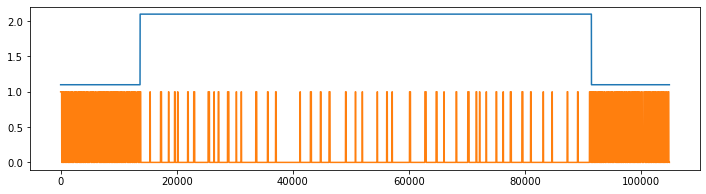

In [201]:
# mask out incorrect trials and target
ctx=xforms.evaluate_step(['nems.xforms.mask_all_but_correct_references',
  {'balance_rep_count': False,
   'include_incorrect': False,
   'generate_evoked_mask': False}], ctx)

plt.figure(figsize=(12,3))
plt.plot(ctx['rec']['state'].as_continuous()[1:2,:].T+1.1)
plt.plot(ctx['rec']['mask'].as_continuous().T)


In [202]:
ctx['rec']['resp'].shape

(38, 104843)

Compute principle components from response data

In [203]:
pc_sig='pca'
xfa = ['nems.preprocessing.resp_to_pc', {'pc_idx': pc_idx, 'pc_sig': pc_sig, 'overwrite_resp': False, 'pc_source': pc_source}]
#resp_to_pc(rec, pc_idx=[pc_idx], resp_sig='resp', pc_sig='pca',
#               pc_count=None, pc_source='all', overwrite_resp=True,
#               compute_power='no', whiten=True, **context)

ctx=xforms.evaluate_step(xfa, ctx)
#ctx['rec'][pc_sig].chans=[f'PC_{pc_source}_{pc_idx}']

print(ctx['rec']['resp'].shape)
#print(ctx2['rec']['resp'].chans)
print(ctx['rec']['pca'].shape)

"""
pc_power= np.nanstd(ctx['rec']['pca'].as_continuous(), axis=1)
pc0 = ctx['rec']['resp'].as_continuous()[0,:]
#plt.figure();plt.plot(pc_power);
plt.figure();plt.plot(pc0[:1000]);
plt.ylabel(ctx['rec']['resp'].chans[0])
"""

[nems.xforms INFO] Evaluating: nems.preprocessing.resp_to_pc
[nems.preprocessing INFO] generating PSTHs for 30 epochs


(38, 104843)
(38, 104843)


"\npc_power= np.nanstd(ctx['rec']['pca'].as_continuous(), axis=1)\npc0 = ctx['rec']['resp'].as_continuous()[0,:]\n#plt.figure();plt.plot(pc_power);\nplt.figure();plt.plot(pc0[:1000]);\nplt.ylabel(ctx['rec']['resp'].chans[0])\n"

In [204]:
ctx['rec']['pca'].shape

(38, 104843)

Compute R/T discrimination and noise axes

In [205]:
import nems_lbhb.dimensionality_reduction as dr

# ==================  add signal with projection of resp onto the noise axis =============================
r=ctx['rec'].copy()

# remove existing mask
del r.signals['mask']

# mask passive trials, correct trials, miss trials. Keep all ref and target
r = r.and_mask(['PASSIVE_EXPERIMENT', 'HIT_TRIAL', 'MISS_TRIAL'])

# ==================  add signal with projection of resp onto the noise axis =============================
r = dr.get_noise_projection(r, epochs=None, collapse=True)
r = dr.get_discrimination_projection(r, epoch1='TARGET', epoch2='REFERENCE', collapse=True)

ctx['rec']['noise_projection']=r['noise_projection']
ctx['rec']['TARGET_vs_REFERENCE_projection']=r['TARGET_vs_REFERENCE_projection']


Compute MI pup and beh projections

In [206]:
resp=ctx['rec']['resp']
mi_p = MI_data.MI_pup_unique.values
mi_p /= np.std(mi_p)
_d = mi_p[np.newaxis, :] @ resp.as_continuous()
mi_pupil = resp._modified_copy(data=_d, name='mi_pupil', chans=['mi_pupil'])
mi_b = MI_data.MI_beh_unique.values
mi_b /= np.std(mi_b)
_d = mi_b[np.newaxis, :] @ resp.as_continuous()
mi_active = resp._modified_copy(data=_d, name='mi_active', chans=['mi_active'])

#plt.figure(figsize=(12,5))
#plt.plot(mi_pupil.as_continuous()[0,:]+2)
#plt.plot(ctx['rec']['mask'].as_continuous().T)
#plt.plot(mi_active.as_continuous()[0,:]+4)

ctx['rec']['mi_pupil']=mi_pupil
ctx['rec']['mi_active']=mi_active

ctx['rec'].signals

{'resp': <nems.signal.RasterizedSignal at 0x7fca1e07ee90>,
 'stim': <nems.signal.RasterizedSignal at 0x7fca1e07e250>,
 'pupil': <nems.signal.RasterizedSignal at 0x7fca1e07efd0>,
 'epoch_onsets': <nems.signal.RasterizedSignal at 0x7fca1e07e3d0>,
 'pupil_raw': <nems.signal.RasterizedSignal at 0x7fca1e07e050>,
 'active': <nems.signal.RasterizedSignal at 0x7fca1e07e750>,
 'state': <nems.signal.RasterizedSignal at 0x7fca1e07e9d0>,
 'state_raw': <nems.signal.RasterizedSignal at 0x7fca1e07e4d0>,
 'mask': <nems.signal.RasterizedSignal at 0x7fca283dd0d0>,
 'pca': <nems.signal.RasterizedSignal at 0x7fca03490e50>,
 'noise_projection': <nems.signal.RasterizedSignal at 0x7fca1c3a0890>,
 'TARGET_vs_REFERENCE_projection': <nems.signal.RasterizedSignal at 0x7fca2871f590>,
 'mi_pupil': <nems.signal.RasterizedSignal at 0x7fca1e0aa350>,
 'mi_active': <nems.signal.RasterizedSignal at 0x7fca1e0aa550>}

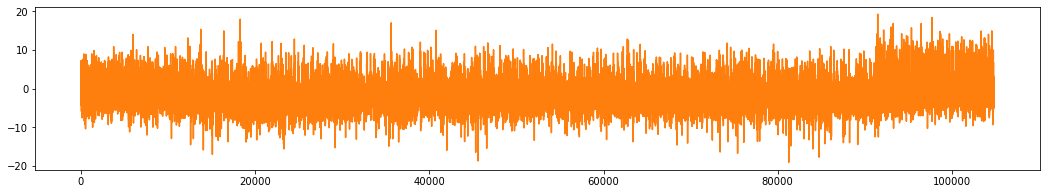

In [207]:
plt.figure(figsize=(18,3))
plt.plot(ctx['rec']['resp'].as_continuous()[0,:])

if projection == "discrim":
    ctx['rec']['resp'] = ctx['rec']['TARGET_vs_REFERENCE_projection']
elif projection == "noise":
    ctx['rec']['resp'] = ctx['rec']['noise_projection']
elif projection == "pc":
    ctx['rec']['resp'] = ctx['rec'][pc_sig].extract_channels(chans=[f'PC{pc_idx}'])
elif projection == "mi_pupil":
    ctx['rec']['resp'] = ctx['rec']['mi_pupil']
elif projection == "mi_active":
    ctx['rec']['resp'] = ctx['rec']['mi_active']
else:
    raise ValueError(f"unknown projection {projection}")
    
plt.plot(ctx['rec']['resp'].as_continuous().T)


In [208]:
ctx['rec']['resp'].shape

(1, 104843)

In [209]:
ctx=xforms.evaluate_step(['nems.xforms.init_from_keywords', {}], ctx)

ctx['modelspec'].phi

[nems.xforms INFO] Evaluating: nems.xforms.init_from_keywords
[nems.initializers INFO] kw: wc.15x2
[nems.initializers INFO] kw: fir.2x8
[nems.initializers INFO] kw: stategain.3
[nems.initializers INFO] kw: lvl.1
[nems.initializers INFO] Setting modelspec[0] input to stim
[nems.utils INFO] model save destination: /auto/data/nems_db/results/307/AMT018a/ld-norm-st.beh.pup-ref.wc.15x2-fir.2x8-stategain.3-lvl.1.jk.nf8.o-init.tf.n-tf.n.2020-07-06T231911


[{'coefficients': array([[0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01,
          0.01, 0.01, 0.01, 0.01],
         [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02,
          0.02, 0.02, 0.02, 0.02]])},
 {'coefficients': array([[ 0.  ,  0.1 , -0.05,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
         [ 0.  ,  0.1 , -0.05,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ]])},
 {'g': array([[1., 0., 0.]]), 'd': array([[0., 0., 0.]])},
 {'level': array([[0.]])}]

In [210]:
ctx=xforms.evaluate_step(['nems.xforms.mask_for_jackknife',
  {'allow_partial_epochs': False, 'njacks': 8}], ctx)
ctx=xforms.evaluate_step(['nems.xforms.jack_subset', {'keep_only': 1}], ctx)

[nems.xforms INFO] Evaluating: nems.xforms.mask_for_jackknife
[nems.xforms INFO] Evaluating: nems.xforms.jack_subset


In [211]:
fit_init_str='nems.tf.cnnlink.fit_tf_init'
#fit_init_str='nems.tf.cnnlink_new.fit_tf_init'
ctx=xforms.evaluate_step(['nems.xforms.fit_wrapper',
  {'tolerance': 3.162277660168379e-06,
   'norm_fir': False,
   'nl_kw': {},
   'max_iter': 10000,
   'use_modelspec_init': True,
   'optimizer': 'Adam',
   'cost_function': 'squared_error',
   'early_stopping_steps': 5,
   'early_stopping_tolerance': 1e-05,
   'learning_rate': 0.01,
   'distr': 'norm',
   'fit_function': fit_init_str,
   'metric': 'nmse',
   'alpha': 0}], ctx)

[nems.xforms INFO] Evaluating: nems.xforms.fit_wrapper
[nems.xforms INFO] ----------------------------------------------------
[nems.xforms INFO] Fitting: nems.tf.cnnlink.fit_tf_init, fit 1/1, fold 1/1
[nems.tf.cnnlink INFO] target_module: ['levelshift', 'relu'] found at modelspec[3].
[nems.tf.cnnlink INFO] Mod 3 (nems.modules.levelshift.levelshift) fixing level to resp mean -1.130
[nems.tf.cnnlink INFO] resp has 1 channels
[nems.tf.cnnlink INFO] nems.modules.weight_channels.basic
nems.modules.fir.basic
nems.modules.state.state_dc_gain
nems.modules.levelshift.levelshift
[nems.tf.cnnlink INFO] seed for this fit: 100
[nems.tf.cnnlink INFO] feat_dims: (243, 58, 15)
[nems.tf.cnnlink INFO] data_dims: (243, 58, 1)
[nems.tf.cnnlink INFO] rand seed for intialization: 100
[nems.modelspec INFO] Modelspec2tf: nems.modules.weight_channels.basic
[nems.modelspec INFO] Modelspec2tf: nems.modules.fir.basic
[nems.modelspec INFO] Modelspec2tf: nems.modules.state.state_dc_gain
[nems.modelspec INFO] Model

In [212]:
fit_str='nems.tf.cnnlink.fit_tf'
#fit_str='nems.tf.cnnlink_new.fit_tf'
ctx=xforms.evaluate_step(['nems.xforms.fit_wrapper',
  {'max_iter': 10000,
   'use_modelspec_init': True,
   'optimizer': 'Adam',
   'cost_function': 'squared_error',
   'fit_function': fit_str,
   'early_stopping_steps': 5,
   'early_stopping_tolerance': 1e-05,
   'learning_rate': 0.01,
   'distr': 'norm'}], ctx)

[nems.xforms INFO] Evaluating: nems.xforms.fit_wrapper
[nems.xforms INFO] ----------------------------------------------------
[nems.xforms INFO] Fitting: nems.tf.cnnlink.fit_tf, fit 1/1, fold 1/1
[nems.tf.cnnlink INFO] seed for this fit: 50
[nems.tf.cnnlink INFO] feat_dims: (243, 58, 15)
[nems.tf.cnnlink INFO] data_dims: (243, 58, 1)
[nems.tf.cnnlink INFO] rand seed for intialization: 50
[nems.modelspec INFO] Modelspec2tf: nems.modules.weight_channels.basic
[nems.modelspec INFO] Modelspec2tf: nems.modules.fir.basic
[nems.modelspec INFO] Modelspec2tf: nems.modules.state.state_dc_gain
[nems.modelspec INFO] Modelspec2tf: nems.modules.levelshift.levelshift
[nems.tf.cnn INFO] Initializing net: setting output, loss, optimizer, globals, tf session
[nems.tf.cnn INFO] Training with batch_size=243, LR=0.01, max_iter=10000, early_stopping_steps=5, early_stopping_tolerance=1e-05, optimizer=Adam.
[nems.tf.cnn INFO] Initial loss=0.9376857
[nems.tf.cnn INFO] 0000 loss=0.9385568, delta=+0.0000000
[ne

In [213]:
ctx=xforms.evaluate_step(['nems.xforms.predict', {}], ctx)

[nems.xforms INFO] Evaluating: nems.xforms.predict


In [214]:
ctx=xforms.evaluate_step(['nems.xforms.add_summary_statistics', {}], ctx)

[nems.xforms INFO] Evaluating: nems.xforms.add_summary_statistics
/auto/users/svd/python/nems/nems/metrics/loglike.py:22: RuntimeWarning: invalid value encountered in log
  denom = np.mean(x2) * np.log(np.mean(x2))
[nems.xforms INFO] Skipping jackknife MI calculations
[nems.metrics.state INFO] state_mod_index for pred, state_raw, baseline
[nems.metrics.state INFO] state_mod_index for pred, state_raw, active
[nems.metrics.state INFO] state_mod_index for pred, state_raw, pupil
[nems.metrics.state INFO] state_mod_index for resp, state_raw, baseline
[nems.metrics.state INFO] state_mod_index for resp, state_raw, active
[nems.metrics.state INFO] state_mod_index for resp, state_raw, pupil


[nems.xforms INFO] Evaluating: nems.xforms.plot_summary
[nems.modelspec INFO] Quickplot: no epoch specified, falling back to "TRIAL"
[nems.modelspec INFO] plotting row 1/7
[nems.modelspec INFO] plotting row 2/7
[nems.modelspec INFO] plotting row 3/7
[nems.modelspec INFO] plotting row 4/7
[nems.modelspec INFO] plotting row 5/7
[nems.modelspec INFO] plotting row 6/7
[nems.modelspec INFO] plotting row 7/7
[nems.modelspec INFO] Quickplot: generated fig with title "Cell: UNKNOWN, Batch: 307, TRIAL #0 ld-norm-st.beh.pup-ref_wc.15x2-fir.2x8-stategain.3-lvl.1_jk.nf8.o-init.tf.n-tf.n"


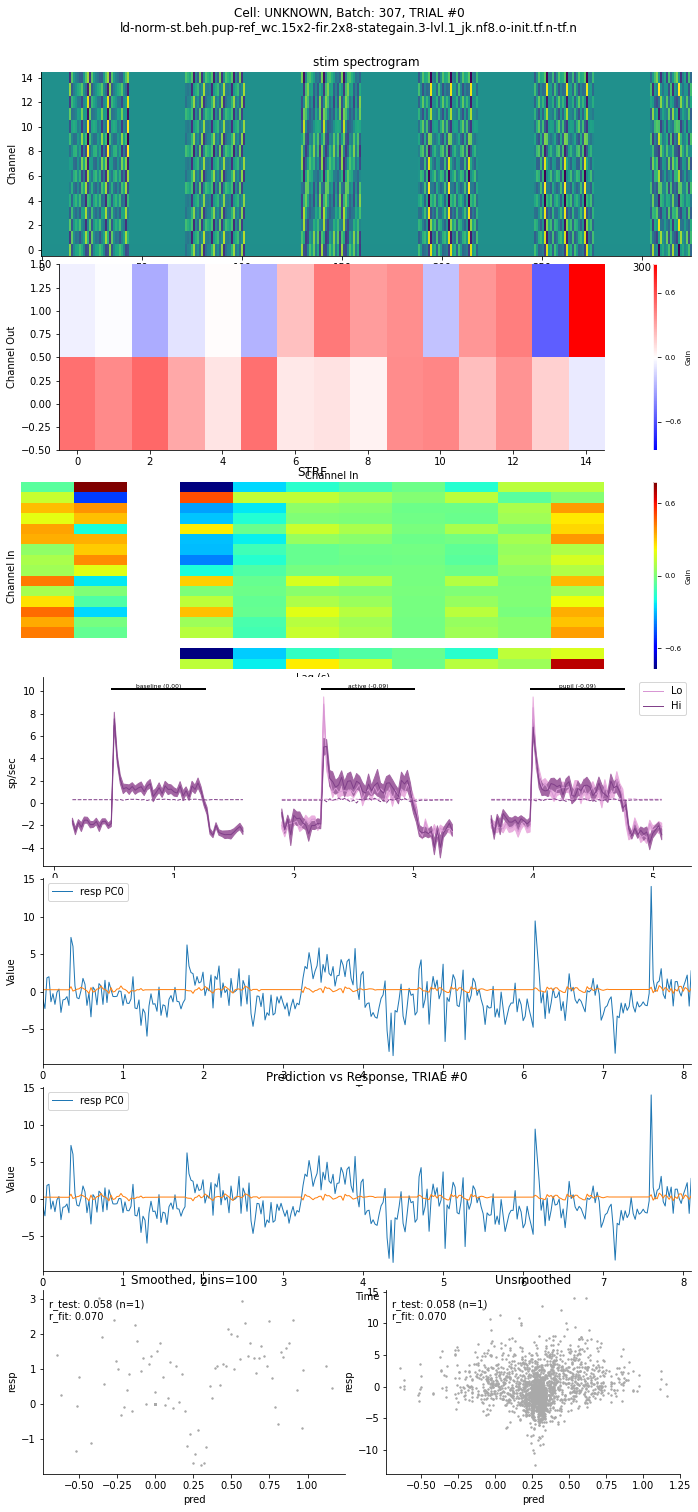

In [215]:
ctx=xforms.evaluate_step(['nems.xforms.plot_summary', {}], ctx)

In [188]:
print(ctx['modelspec'][1]['plot_fns'])
print(ctx['modelspec'][1]['plot_fn_idx'])


['nems.plots.api.mod_output', 'nems.plots.api.spectrogram_output', 'nems.plots.api.strf_heatmap', 'nems.plots.api.strf_local_lin', 'nems.plots.api.strf_timeseries', 'nems.plots.api.fir_output_all']
2


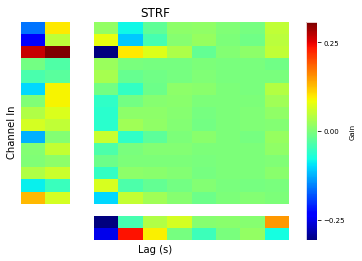

In [189]:
ctx['modelspec'].plot(mod_index=1, plot_fn_idx=2)

prediction correlation: 0.124


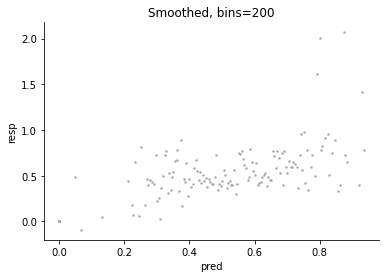

In [190]:
from nems.plots.api import plot_scatter
smoothing_bins=200
plot_scatter(ctx['val']['pred'], ctx['val']['resp'], smoothing_bins=smoothing_bins, title=f'Smoothed, bins={smoothing_bins}')
print(f"prediction correlation: {ctx['modelspec'].meta['r_test'][0][0]:.3f}")
      

In [236]:
ctx['modelspec'].get_longname()

'ld-norm-st.beh0.pup0-ref.wc.15x2-fir.2x8-lvl.1-stategain.3-lvl.1.jk.nf8.o-init.tf.n-tf.n.2020-06-02T220504'

### save results ###

In [237]:
modelspec = ctx['modelspec']
meta=modelspec.meta
destination = os.path.join(results_dir, str(batch), xforms.get_meta(ctx)['cellid'],
                           modelspec.get_longname())
print(destination)

/Users/svd/python/nems/results/307/TAR010c-19-1/ld-norm-st.beh0.pup0-ref.wc.15x2-fir.2x8-lvl.1-stategain.3-lvl.1.jk.nf8.o-init.tf.n-tf.n.2020-06-02T220504


In [238]:
# save to file
log.info('Saving modelspec(s) to {0} ...'.format(destination))
xforms.save_analysis(destination,
                     recording=ctx['rec'],
                     modelspec=modelspec,
                     xfspec=xfspec,
                     figures=ctx['figures'], 
                     log='Empty log')



[__main__ INFO] Saving modelspec(s) to /Users/svd/python/nems/results/307/TAR010c-19-1/ld-norm-st.beh0.pup0-ref.wc.15x2-fir.2x8-lvl.1-stategain.3-lvl.1.jk.nf8.o-init.tf.n-tf.n.2020-06-02T220504 ...


{'savepath': '/Users/svd/python/nems/results/307/TAR010c-19-1/ld-norm-st.beh0.pup0-ref.wc.15x2-fir.2x8-lvl.1-stategain.3-lvl.1.jk.nf8.o-init.tf.n-tf.n.2020-06-02T220504/'}

In [239]:
import nems.db as nd
print(nd._get_db_uri())

sqlite:////Users/svd/python/nems/recordings/nems.db


In [240]:
# save summary to a database
log.info('Saving metadata to db  ...')
modelspec.meta['modelpath'] = destination
modelspec.meta['figurefile'] = destination + 'figure.0000.png'
nd.update_results_table(modelspec)


[__main__ INFO] Saving metadata to db  ...


4

### reload the model from db ###

In [211]:
# batch = 307
# cellid = "TAR010c-14-1"
# modelname = "ld-norm-st.beh.pup-ref_wc.15x2-fir.2x8-lvl.1-stategain.3-lvl.1_jk.nf8.o-init.tf.n-tf.n"
batch, cellid, modelname

(307,
 'TAR010c-27-2',
 'ld-norm-st.beh0.pup0-ref_wc.15x2-fir.2x8-lvl.1-stategain.3-lvl.1_jk.nf8.o-init.tf.n-tf.n')

In [212]:
# find the results in the database
d=nd.get_results_file(batch=batch, cellids=[cellid], modelnames=[modelname])
filepath = d['modelpath'][0] + '/'
filepath

'/Users/svd/python/nems/results/307/TAR010c-27-2/ld-norm-st.beh0.pup0-ref.wc.15x2-fir.2x8-lvl.1-stategain.3-lvl.1.jk.nf8.o-init.tf.n-tf.n.2020-06-02T215847/'

In [213]:
# load and display results
xfspec, ctx = xforms.load_analysis(filepath, eval_model=True)


[nems.xforms INFO] Loading xfspec and context from /Users/svd/python/nems/results/307/TAR010c-27-2/ld-norm-st.beh0.pup0-ref.wc.15x2-fir.2x8-lvl.1-stategain.3-lvl.1.jk.nf8.o-init.tf.n-tf.n.2020-06-02T215847/...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] xf argument recording_uri_list overlaps with existing context key: nems.xforms.load_recordings
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.xforms INFO] Extracting cellid(s) TAR010c-14-1
[nems.preprocessing INFO] Adding to epoch_onsets: TRIAL with shift = 0
[nems.xforms INFO] Evaluating: nems.xforms.normalize_sig
[nems.xforms INFO] Evaluating: nems.xforms.normalize_sig
[nems.xforms INFO] Evaluating: nems.xforms.make_state_signal
[nems.xforms INFO] Evaluating: nems.xforms.mask_all_but_correct_references
[nems.xforms INFO] Evaluating: nems.xforms.init_from_keywords
[nems.xforms INFO] Evaluating: nems.xforms.mask_for_jackknife
[nems.xforms INFO] Evaluating: nems.xforms.jack_subset
[nems.xf

Get saved data from Results table

In [217]:

modelnames = ["ld-norm-st.beh.pup-ref_" + modelspecname + "_jk.nf8.o-init.tf.n-tf.n",
              "ld-norm-st.beh0.pup0-ref_" + modelspecname + "_jk.nf8.o-init.tf.n-tf.n"]

d = nd.batch_comp(batch=batch, modelnames=modelnames)
d

,ld-norm-st.beh.pup-ref_wc.15x2-fir.2x8-lvl.1-stategain.3-lvl.1_jk.nf8.o-init.tf.n-tf.n,ld-norm-st.beh0.pup0-ref_wc.15x2-fir.2x8-lvl.1-stategain.3-lvl.1_jk.nf8.o-init.tf.n-tf.n
cellid,,
TAR010c-14-1,0.042854,NaN
TAR010c-19-1,0.175537,NaN


In [218]:
print(modelname)
print(modelnames[1])

ld-norm-st.beh0.pup0-ref_wc.15x2-fir.2x8-lvl.1-stategain.3-lvl.1_jk.nf8.o-init.tf.n-tf.n
ld-norm-st.beh0.pup0-ref_wc.15x2-fir.2x8-lvl.1-stategain.3-lvl.1_jk.nf8.o-init.tf.n-tf.n


Find all models fit for this cell/batch

In [ ]:
d=nd.get_results_file(batch=batch, cellids=[cellid])
d[['cellid','modelname','r_fit','r_test','modelpath']]

### some other inspection stuff ###

Get some basic info about the fit

In [ ]:
print("List of modules in this modelspec:")
print(modelspec)

print("Number of modules: {}".format(len(modelspec)))
print("Number of fits: {}".format(modelspec.fit_count))

Plotting support built in to ModelSpec:

In [ ]:
modelspec[0]['plot_fns']

In [ ]:
modelspec[0]['plot_fn_idx']=1

In [ ]:
modelspec.plot?

In [ ]:
modelspec.plot(mod_index=0, plot_fn_idx=1, rec=ctx['val'])

In [ ]:
modelspec.recording = ctx['val']
print(modelspec[2]['fn'])
modelspec.plot(mod_index=2)

In [ ]:
modelspec.recording = ctx['val']
modelspec[0]['plot_fn_idx']=3
fig=modelspec.quickplot()

In [ ]:
print("Recording views:", ctx['val'].view_count)

# list of views for looping through fit sets (eg, nfold fits)
ctx['val'].views()